# Data Preprocessing

Using two main datasets (PHL Data and AT-HYG Data), aswell as one correspondance dataset (Exoplanet Archives NASA), I will preprocess the data.

The goals are the following : 
- Perform a prior extraction of columns I want for my project ;
- Deal with large missing values : deleting highly missing features (subjective threshold) ;
- Feature Engineering : Additional variables.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from pyampute.exploration.mcar_statistical_tests import MCARTest
pd.set_option('display.max_columns', None)

In [2]:
# Function to remove columns if percentage of missing values is higher than a threshold (among numeric columns)

def remove_col(df, threshold = 30):
    df_num = df.select_dtypes(include=np.number)
    df_non_num = df.select_dtypes('object')
    cols_to_drop = [col for col in df_num.columns if (df_num[col].isna().sum()/len(df_num[col]))*100 > threshold]
    df_num.drop(cols_to_drop, axis=1, inplace=True)
    print(f'{(cols_to_drop)} have been deleted')
    return pd.concat([df_non_num, df_num], axis=1)

Importing the first dataset.

In [3]:
df_phl = pd.read_csv('data/original/phl_exoplanet_catalog.csv')

Only some columns are interesting for the work. Thus, I drop all others.

In [4]:
# Keep only some columns

columns_of_interest = ['P_NAME', 'P_MASS', 
 'P_RADIUS', 'P_YEAR', 'P_PERIOD', 
 'P_SEMI_MAJOR_AXIS', 'P_ECCENTRICITY', 
 'P_INCLINATION', 
 'P_IMPACT_PARAMETER', 'P_DETECTION', 
 'P_ESI', 'P_HABITABLE', 'P_TYPE_TEMP', 
 'P_HABZONE_CON', 'P_HABZONE_OPT', 'P_TYPE', 
 'P_FLUX', 'P_DISTANCE', 'P_DENSITY', 
 'P_GRAVITY', 'S_NAME', 'S_RA', 
 'S_DEC', 'S_MAG', 'S_DISTANCE', 
 'S_METALLICITY', 'S_MASS', 'S_RADIUS', 
 'S_TYPE', 'S_AGE', 'S_TEMPERATURE',
 'S_LUMINOSITY', 'S_CONSTELLATION', 'P_TEMP_EQUIL']

df_phl_cleaned = df_phl[columns_of_interest]
print(f'{df_phl.shape[1] - df_phl_cleaned.shape[1]} columns have been deleted')

69 columns have been deleted


I remove potential duplicates.

In [5]:
df_phl_cleaned_no_dup = df_phl_cleaned.drop_duplicates(subset=['P_NAME'], keep='first')
print(f'{df_phl_cleaned.shape[0] - df_phl_cleaned_no_dup.shape[0]} duplicated rows have been deleted')

0 duplicated rows have been deleted


I remove columns that have a too high ratio of missing values (> 30%) : I won't be able to imput those columns and have a statistically significant sample.

In [6]:
df_phl_no_na_1 = remove_col(df_phl_cleaned_no_dup, 50)

[] have been deleted


I add a column for whether the stars host many planets.

In [7]:
group_size = df_phl_no_na_1.groupby('S_NAME')['S_NAME'].transform('size')
df_phl_no_na_1['high_multiplanetary'] = (group_size > 1).astype(int)

Checking the final dataframe: it's perfect.

In [8]:
df_phl_no_na_1.isna().sum()

P_NAME                    1
P_DETECTION               1
P_TYPE_TEMP             168
P_TYPE                    9
S_NAME                    1
S_TYPE                 3364
S_CONSTELLATION           0
P_MASS                  135
P_RADIUS                 18
P_YEAR                    0
P_PERIOD                184
P_SEMI_MAJOR_AXIS       276
P_ECCENTRICITY          676
P_INCLINATION          1239
P_IMPACT_PARAMETER     1401
P_ESI                   168
P_HABITABLE               0
P_HABZONE_CON             0
P_HABZONE_OPT             0
P_FLUX                  168
P_DISTANCE                4
P_DENSITY               144
P_GRAVITY               144
S_RA                      0
S_DEC                     0
S_MAG                   152
S_DISTANCE               17
S_METALLICITY           354
S_MASS                    4
S_RADIUS                174
S_AGE                  1097
S_TEMPERATURE           153
S_LUMINOSITY            167
P_TEMP_EQUIL            168
high_multiplanetary       0
dtype: int64

Now, we work with AT-HYG data and clean it.

In [9]:
# Cleaning AT-HYG data

df_at_hyg = pd.read_csv('data/original/athyg_v22.csv')

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_6924\1889661199.py:3: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df_at_hyg = pd.read_csv('data/original/athyg_v22.csv')


Drop some columns not interesting

In [10]:
df_at_hyg

,id,tyc,gaia,hyg,hip,hd,hr,gl,bayer,flam,con,proper,ra,dec,pos_src,dist,x0,y0,z0,dist_src,mag,absmag,ci,mag_src,rv,rv_src,pm_ra,pm_dec,pm_src,vx,vy,vz,spect,spect_src
0,1,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sol,0.000000,0.000000,OTHER,0.0000,0.000005,0.000,0.000,OTHER,-26.700,4.850,0.656,OTHER,NaN,OTHER,NaN,NaN,OTHER,NaN,NaN,NaN,G2 V,OTHER
1,2,4669-731-1,2.443095e+18,NaN,NaN,224701.0,NaN,NaN,NaN,NaN,Psc,NaN,0.000023,-5.494362,T,509.1956,506.856000,0.003,-48.754,G_R3,9.239,0.705,1.117,T,-17.371,G_R3,22.498,-11.301,G_R3,-19.904,54.306,-25.490,G8 IV,T
2,3,1-381-1,NaN,1.0,1.0,224700.0,NaN,NaN,NaN,NaN,Psc,NaN,0.000060,1.089008,T,219.7802,219.741000,0.003,4.177,HIP,9.100,2.390,0.482,HIP,NaN,NONE,-5.200,-1.880,HYG,0.037,-5.418,-1.958,F3 V,T
3,4,3258-1994-1,3.957096e+17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cas,NaN,0.000067,52.177826,T,696.9990,427.409000,0.007,550.572,G_R3,11.816,2.600,1.228,T,-27.782,G_R3,14.421,1.836,G_R3,-21.830,47.647,-18.225,NaN,NONE
4,5,5260-880-1,2.422928e+18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cet,NaN,0.000074,-9.856494,T,501.7967,494.390000,0.010,-85.898,G_R3,12.213,3.710,1.224,T,-44.539,G_R3,-10.292,-17.136,G_R3,-50.859,-24.482,-32.536,NaN,NONE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2552160,2552161,1722-672-1,2.772098e+18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Peg,NaN,23.999944,15.477908,T,497.4170,479.377000,-0.007,132.744,G_R3,12.160,3.676,0.031,T,-5.661,G_R3,28.069,-3.353,G_R3,-3.345,66.187,-9.130,NaN,NONE
2552161,2552162,6988-385-1,2.333399e+18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Scl,NaN,23.999950,-27.719017,T,163.5052,144.741000,-0.002,-76.052,G_R3,11.530,5.462,0.804,T,-13.195,G_R3,-23.053,-47.450,G_R3,-28.788,-17.868,-26.420,NaN,NONE
2552162,2552163,3241-1424-1,1.921555e+18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,And,NaN,23.999959,42.081960,T,252.5433,187.434000,-0.002,169.253,G_R3,11.290,4.278,0.792,T,NaN,NONE,11.916,-30.287,G_R3,24.301,14.265,-26.911,NaN,NONE
2552163,2552164,3660-1372-1,1.994790e+18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cas,NaN,23.999992,56.289723,T,1757.2998,975.290000,-0.002,1461.818,G_R3,11.534,0.310,2.178,T,-57.914,G_R3,-7.611,-2.789,G_R3,-12.816,-63.404,-61.069,NaN,NONE


In [11]:
columns_of_interest = ['id', 'hip', 'hd', 'hyg',
                       'ra', 'dec', 'dist',
                       'x0', 'y0', 'z0',
                       'mag', 'absmag', 'rv',
                       'spect', 'ci', 'con', 'pos_src', 'dist_src', 'mag_src',
                       'rv_src', 'pm_ra', 'pm_dec', 'pm_src', 'vx', 'vy', 'vz',
                       'spect_src']

df_at_hyg_cleaned = df_at_hyg[columns_of_interest]

Removing duplicates

In [12]:
df_at_hyg_no_dup = df_at_hyg_cleaned.drop_duplicates(subset=['id'], keep='first')
print(f'{df_at_hyg_cleaned.shape[0] - df_at_hyg_no_dup.shape[0]} duplicated rows have been deleted')

0 duplicated rows have been deleted


In [13]:
# Drop NAN

df_at_hyg_no_na_1 = df_at_hyg_no_dup.dropna(axis=1, how='all')
print(f'{df_at_hyg_no_na_1.shape[1] - df_at_hyg_no_dup.shape[1]} columns deleted')

0 columns deleted


Check pattern of missing values, but only for a random sample of 100000.

<AxesSubplot: >

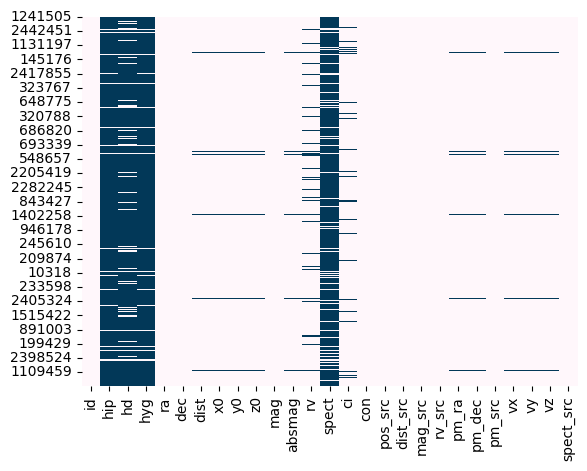

In [14]:
sns.heatmap(df_at_hyg_no_na_1.sample(100000).isna(), cbar=False, cmap='PuBu')

Blue : missing values.

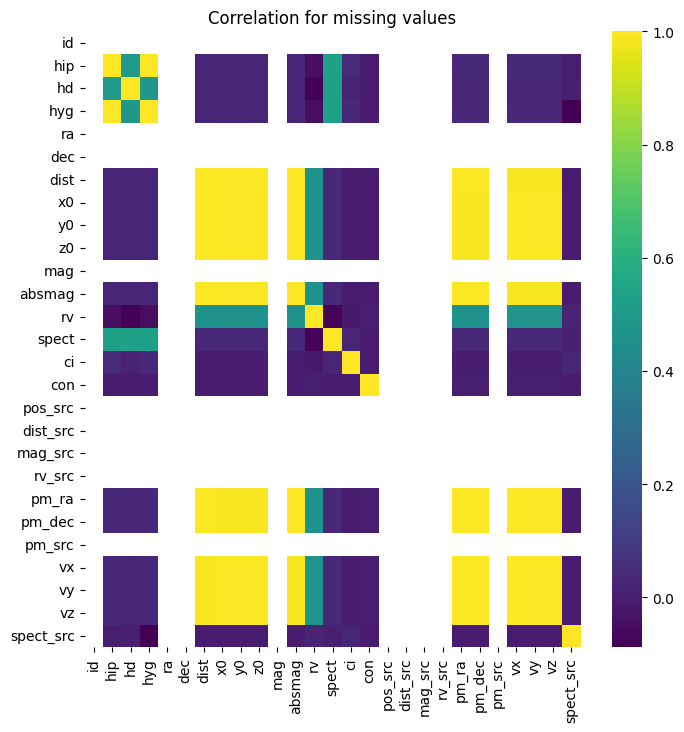

In [15]:
plt.figure(figsize=(8,8))
heatmap = sns.heatmap(df_at_hyg_no_na_1.isna().corr(), cbar=True, cmap='viridis')
heatmap.set_title('Correlation for missing values')
plt.show()

MCAR

In [16]:
mt = MCARTest(method='little')
print(mt.little_mcar_test(df_at_hyg_no_na_1.select_dtypes(include=np.number)))

0.0


In [17]:
# Intermediary dataset to make the bridge between df_phl and df_at_hyg

df_planetary_systems = pd.read_csv('data/original/planetarysystems_nasa_archive.csv', skiprows=286)

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_6924\139907246.py:3: DtypeWarning: Columns (3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_planetary_systems = pd.read_csv('data/original/planetarysystems_nasa_archive.csv', skiprows=286)


In [18]:
columns_of_interest = ['pl_name', 'hostname', 'hd_name',
                       'hip_name']

df_planetary_systems_cleaned = df_planetary_systems[columns_of_interest]

In [19]:
df_planetary_systems_cleaned = df_planetary_systems_cleaned.drop_duplicates(subset=['pl_name'], keep='first')

In [20]:
# Drop NAN

df_planetary_systems_cleaned = df_planetary_systems_cleaned.dropna(axis=1, how='all')

In [21]:
df_planetary_systems_cleaned.head()

,pl_name,hostname,hd_name,hip_name
0,11 Com b,11 Com,HD 107383,HIP 60202
3,11 UMi b,11 UMi,HD 136726,HIP 74793
6,14 And b,14 And,HD 221345,HIP 116076
9,14 Her b,14 Her,HD 145675,HIP 79248
17,16 Cyg B b,16 Cyg B,HD 186427,HIP 96901


In [22]:
import re

In [23]:
# Convert 'hip_name' to string first to avoid any type-related errors

df_planetary_systems_cleaned['hip_name'] = df_planetary_systems_cleaned['hip_name'].astype(str)

df_planetary_systems_cleaned['hip_name'] = df_planetary_systems_cleaned['hip_name'].apply(lambda x: re.sub("[^0-9]", "", x))


In [24]:
# Convert 'hd_name' to string first to avoid any type-related errors
df_planetary_systems_cleaned['hd_name'] = df_planetary_systems_cleaned['hd_name'].astype(str)

df_planetary_systems_cleaned['hd_name'] = df_planetary_systems_cleaned['hd_name'].apply(lambda x: re.sub("[^0-9]", "", x))

In [25]:
df_planetary_systems_cleaned.head()

,pl_name,hostname,hd_name,hip_name
0,11 Com b,11 Com,107383,60202
3,11 UMi b,11 UMi,136726,74793
6,14 And b,14 And,221345,116076
9,14 Her b,14 Her,145675,79248
17,16 Cyg B b,16 Cyg B,186427,96901


In [26]:
df_planetary_systems_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5528 entries, 0 to 35096
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   pl_name   5528 non-null   object
 1   hostname  5528 non-null   object
 2   hd_name   5528 non-null   object
 3   hip_name  5528 non-null   object
dtypes: object(4)
memory usage: 215.9+ KB


In [27]:
# In df_phl, add hip and hd name based on pl_name in df_planetary_systems

df_phl_transformed = pd.merge(df_phl_no_na_1, df_planetary_systems_cleaned[['pl_name', 'hip_name', 'hd_name']],
                     left_on='P_NAME', right_on='pl_name', how='left')

df_phl_transformed.drop('pl_name', axis=1, inplace=True)

In [28]:
df_phl_transformed.head()

,P_NAME,P_DETECTION,P_TYPE_TEMP,P_TYPE,S_NAME,S_TYPE,S_CONSTELLATION,P_MASS,P_RADIUS,P_YEAR,P_PERIOD,P_SEMI_MAJOR_AXIS,P_ECCENTRICITY,P_INCLINATION,P_IMPACT_PARAMETER,P_ESI,P_HABITABLE,P_HABZONE_CON,P_HABZONE_OPT,P_FLUX,P_DISTANCE,P_DENSITY,P_GRAVITY,S_RA,S_DEC,S_MAG,S_DISTANCE,S_METALLICITY,S_MASS,S_RADIUS,S_AGE,S_TEMPERATURE,S_LUMINOSITY,P_TEMP_EQUIL,high_multiplanetary,hip_name,hd_name
0,11 Com b,Radial Velocity,Hot,Jovian,11 Com,G8 III,Coma Berenices,6165.86330,12.1068,2007.0,326.03000,1.290000,0.231000,NaN,NaN,0.083004,0,0,0,108.075780,1.324418,3.474608,42.066381,185.17878,17.793252,4.72307,93.1846,-0.350,2.70,19.00,NaN,4742.0,174.984670,813.07498,0,60202,107383
1,11 UMi b,Radial Velocity,Hot,Jovian,11 UMi,K4 III,Ursa Minor,4684.78480,12.2189,2009.0,516.21997,1.530000,0.080000,NaN,NaN,0.081792,0,0,0,115.348340,1.534896,2.567990,31.378012,229.27460,71.823943,5.01300,125.3210,-0.020,2.78,29.79,1.56,4213.0,269.153480,833.92148,0,74793,136726
2,14 And b,Radial Velocity,Hot,Jovian,14 And,K0 III,Andromeda,1525.57440,12.8915,2008.0,185.84000,0.830000,0.000000,NaN,NaN,0.081758,0,0,0,84.109261,0.830000,0.712071,9.179658,352.82415,39.235837,5.23133,75.4392,-0.240,2.20,11.00,4.50,4813.0,57.942870,771.53541,0,116076,221345
3,14 Her b,Radial Velocity,Cold,Jovian,14 Her,K0 V,Hercules,2586.74170,12.5552,2002.0,1765.03890,2.773069,0.372689,144.652,NaN,0.163310,0,0,0,0.098526,2.965655,1.307020,16.409895,242.60210,43.816362,6.61935,17.9323,0.405,0.91,0.93,3.90,5338.0,0.703072,138.83404,1,79248,145675
4,16 Cyg B b,Radial Velocity,Warm,Jovian,16 Cyg B,G3 V,Cygnus,565.73385,13.4520,1996.0,798.50000,1.660000,0.680000,NaN,NaN,0.368405,0,1,1,0.618806,2.043792,0.232408,3.126356,295.46564,50.516824,6.21500,21.1397,0.060,1.08,1.13,7.40,5750.0,1.250259,202.21422,0,96901,186427


In [29]:
## Add a column stating whether a star host an exoplanet, and whether it is high multi planetary or not, in at-hyg data based on df_phl hid

# Create a dictionary for quick look-up of P_ESI values based on HIP and HD names
esi_hip = {str(int(h)): esi for h, esi in zip(df_phl_transformed['hip_name'], df_phl_transformed['P_ESI']) if pd.notna(h) and h != ''}
esi_hd = {str(int(h)): esi for h, esi in zip(df_phl_transformed['hd_name'], df_phl_transformed['P_ESI']) if pd.notna(h) and h != ''}

# Initialize 'host_exoplanet' column to False
df_at_hyg_no_na_1['host_exoplanet'] = False

for i in range(len(df_at_hyg_no_na_1)):
    is_host = False

    # Check HIP names
    if pd.notna(df_at_hyg_no_na_1['hip'][i]):
        hostname_hip = str(int(df_at_hyg_no_na_1['hip'][i]))
        if hostname_hip in esi_hip and 0.0 <= esi_hip[hostname_hip] <= 1.0:
            is_host = True

    # Check HD names
    if pd.notna(df_at_hyg_no_na_1['hd'][i]):
        hostname_hd = str(int(df_at_hyg_no_na_1['hd'][i]))
        if hostname_hd in esi_hd and 0.0 <= esi_hd[hostname_hd] <= 1.0:
            is_host = True

    # Update the 'host_exoplanet' column
    df_at_hyg_no_na_1.at[i, 'host_exoplanet'] = is_host

In [30]:
# For this high multiplanetary

hip_to_multiplanetary = df_phl_transformed.set_index('hip_name')['high_multiplanetary'].to_dict()
hd_to_multiplanetary = df_phl_transformed.set_index('hd_name')['high_multiplanetary'].to_dict()

df_at_hyg_no_na_1['high_multiplanetary'] = None

for i in range(len(df_at_hyg_no_na_1)):
    hip = df_at_hyg_no_na_1['hip'][i]
    hd = df_at_hyg_no_na_1['hd'][i]

    if pd.notna(hip):
        hip = str(int(hip))
        if hip in hip_to_multiplanetary:
            df_at_hyg_no_na_1.loc[i, 'high_multiplanetary'] = hip_to_multiplanetary[hip]

    elif pd.notna(hd):
        hd = str(int(hd))
        if hd in hd_to_multiplanetary:
            df_at_hyg_no_na_1.loc[i, 'high_multiplanetary'] = hd_to_multiplanetary[hd]


In [31]:
df_at_hyg_no_na_1.head()

,id,hip,hd,hyg,ra,dec,dist,x0,y0,z0,mag,absmag,rv,spect,ci,con,pos_src,dist_src,mag_src,rv_src,pm_ra,pm_dec,pm_src,vx,vy,vz,spect_src,host_exoplanet,high_multiplanetary
0,1,NaN,NaN,0.0,0.000000,0.000000,0.0000,0.000005,0.000,0.000,-26.700,4.850,NaN,G2 V,0.656,NaN,OTHER,OTHER,OTHER,OTHER,NaN,NaN,OTHER,NaN,NaN,NaN,OTHER,False,None
1,2,NaN,224701.0,NaN,0.000023,-5.494362,509.1956,506.856000,0.003,-48.754,9.239,0.705,-17.371,G8 IV,1.117,Psc,T,G_R3,T,G_R3,22.498,-11.301,G_R3,-19.904,54.306,-25.490,T,False,None
2,3,1.0,224700.0,1.0,0.000060,1.089008,219.7802,219.741000,0.003,4.177,9.100,2.390,NaN,F3 V,0.482,Psc,T,HIP,HIP,NONE,-5.200,-1.880,HYG,0.037,-5.418,-1.958,T,False,None
3,4,NaN,NaN,NaN,0.000067,52.177826,696.9990,427.409000,0.007,550.572,11.816,2.600,-27.782,NaN,1.228,Cas,T,G_R3,T,G_R3,14.421,1.836,G_R3,-21.830,47.647,-18.225,NONE,False,None
4,5,NaN,NaN,NaN,0.000074,-9.856494,501.7967,494.390000,0.010,-85.898,12.213,3.710,-44.539,NaN,1.224,Cet,T,G_R3,T,G_R3,-10.292,-17.136,G_R3,-50.859,-24.482,-32.536,NONE,False,None


In [32]:
# Initialize the matched column to False

df_phl_transformed['matched'] = False
list_hip_exoplanets = set(df_at_hyg_no_na_1[df_at_hyg_no_na_1['host_exoplanet']]['hip'])
list_hd_exoplanets = set(df_at_hyg_no_na_1[df_at_hyg_no_na_1['host_exoplanet']]['hd'])

# Iterate over df_phl_transformed
for i in range(len(df_phl_transformed)):
    if (pd.notna(df_phl_transformed['hip_name'][i]) and df_phl_transformed['hip_name'][i] != ''):
        hip_name = df_phl_transformed['hip_name'][i]
        if float(hip_name) in list_hip_exoplanets:
            df_phl_transformed.at[i, 'matched'] = True
            continue

    if pd.notna(df_phl_transformed['hd_name'][i] and df_planetary_systems['hd_name'][i] != ''):
        hd_name = df_phl_transformed['hd_name'][i]
        if hd_name in list_hd_exoplanets:
            print(hd_name)
            df_phl_transformed.at[i, 'matched'] = True


In [33]:
# Matched

len(df_at_hyg_no_na_1[df_at_hyg_no_na_1['host_exoplanet'] == True])

751

In [34]:
# Unmatched

len(df_phl_transformed) - len(df_at_hyg_no_na_1[df_at_hyg_no_na_1['host_exoplanet'] == True])

4469

In [35]:
# Characteristics of unmatched

unmatched = df_phl_transformed[df_phl_transformed['matched']==False]

In [36]:
unmatched.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4274 entries, 7 to 5219
Data columns (total 38 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   P_NAME               4273 non-null   object 
 1   P_DETECTION          4273 non-null   object 
 2   P_TYPE_TEMP          4106 non-null   object 
 3   P_TYPE               4268 non-null   object 
 4   S_NAME               4273 non-null   object 
 5   S_TYPE               932 non-null    object 
 6   S_CONSTELLATION      4274 non-null   object 
 7   P_MASS               4147 non-null   float64
 8   P_RADIUS             4261 non-null   float64
 9   P_YEAR               4274 non-null   float64
 10  P_PERIOD             4103 non-null   float64
 11  P_SEMI_MAJOR_AXIS    4020 non-null   float64
 12  P_ECCENTRICITY       3630 non-null   float64
 13  P_INCLINATION        3729 non-null   float64
 14  P_IMPACT_PARAMETER   3713 non-null   float64
 15  P_ESI                4106 non-null   f

In [37]:
# Almost only missing values in hd and hip ! (Impossible to match therefore)

In [38]:
df_at_hyg_transformed = df_at_hyg_no_na_1.copy()

In [39]:
# Save as CSV the dataframes

df_at_hyg_transformed.to_csv('data/at_hyg_data.csv', index=False)
df_planetary_systems_cleaned.to_csv('data/planetary_systems_data.csv', index=False)
df_phl_transformed.to_csv('data/phl_data.csv', index=False)